# Images as Data and Multi-wavelength Images of Galaxies

In this Notebook, you will use data from a variety of sources to explore just a handful of ways that
extragalactic astronomers use images as data. The example galaxy will be Centaurus A, which has radio (and X-ray) jets indicating the prescense of an accreting supermassive black hole. 

_This python exercise notebook written by Karen Masters, March 2024 for ASTR352, Haverford College._

In the end, you should have found an answer to the following questions:

- How can I get raw data out of an image stored as jpg or fits files and plot in different ways.
- What are wcs co-ordinates? 
- How can I align images with different scales and resolutions if they have wcs co-ordinates to overplot data from different wavelengths

This notebook was tested in a container under the "Astronomy compute image" on [Sciserver.org](https://sciserver.org/). 

Resources used: 
* [Reproject](https://pypi.org/project/reproject/) and it's [Documentation at Astropy](https://reproject.readthedocs.io/en/stable/index.html#)
* [ASTR204 HW5 "Images of Supernova Remnant"](https://github.com/karenlmasters/ASTR204JupyterAssignments/blob/master/Homework5_Images_of_SupernovaRemnant.ipynb)
* [Read a FITS image and plot (astropy)](https://docs.astropy.org/en/stable/generated/examples/io/plot_fits-image.html#sphx-glr-generated-examples-io-plot-fits-image-py)
* [Matplotlib colormaps](https://matplotlib.org/stable/users/explain/colors/colormaps.html)
* [Working with FITS Cubes (astropy)](https://learn.astropy.org/tutorials/FITS-cubes.html)

Other useful stuff: 
* [Plotting Images and Contours (astropy)](https://docs.astropy.org/en/stable/visualization/wcsaxes/images_contours.html)
* [Creating Colour RGB images (astropy)](https://docs.astropy.org/en/stable/visualization/rgb.html)

In [1]:
#Import statements

#Basic things
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

#Fits read in
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

#Image normalization/color maps
from matplotlib.colors import LogNorm
from matplotlib import colormaps

#Co-ordinate system stuff
from astropy.wcs import WCS

#Radio data
from spectral_cube import SpectralCube



## The Data in a JPG Image

You are probably familiar with JPG (or [JPEG](https://en.wikipedia.org/wiki/JPEG)) files as a standard image file. Created in 1992, by the "Joint Photographic Experts Group" this data file saves computer space in a way which is usually undetectable to humans looking at an image, but the data compression algorithm means that the data they store are unsuitable for scientific analysis in most cases. 

But like all images, it's still just data - arrays of pixel values (in three colours) which are displayed by image commands. 

### Centaurus A

[Centaurus A](https://en.wikipedia.org/wiki/Centaurus_A) (or NGC 5128) is one of the closest radio galaxies to us. A radio galaxy is (usually) a galaxy with an actively accreting supermassive black hole. The accretion often creates jets outflowing at the poles of the black hole which can be observed in radio, X-ray (and sometimes optical).  Sadly Cen A is only visible from the southern hemisphere (or close to the equator). I picked this as my example galaxy, and I'm using the main jpg illustration from it's Wikipedia page. 

_QUESTION: Search for any other image of Centaurus A on Google. What's interesting to you about this galaxy?_

### First Open the File and Display the Image

Notice the axis numbers - these are pixel counts. 

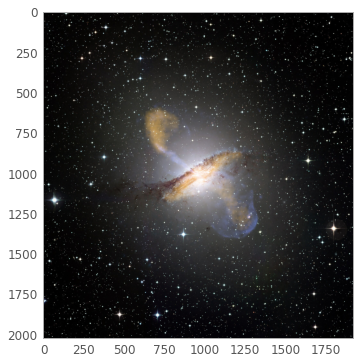

In [2]:
img = plt.imread('ESO_Centaurus_A_LABOCA.jpg')
plt.imshow(img)
plt.grid(None)
plt.show()

In [3]:
print(img.shape)

(2022, 1920, 3)


_QUESTION: How many pixels does your image have?_ My Cen A galaxy image has 2022x1920 pixels

_QUESTION: How many layers?_ Most JPGS are RGB, with B in layer 0 (in python indexes), then G then R. This one is no different with three layers.

We can also explore just single layers of this image. For example, to see each layer in the Whirlpool galaxy image I can do the below. Do this for your image.

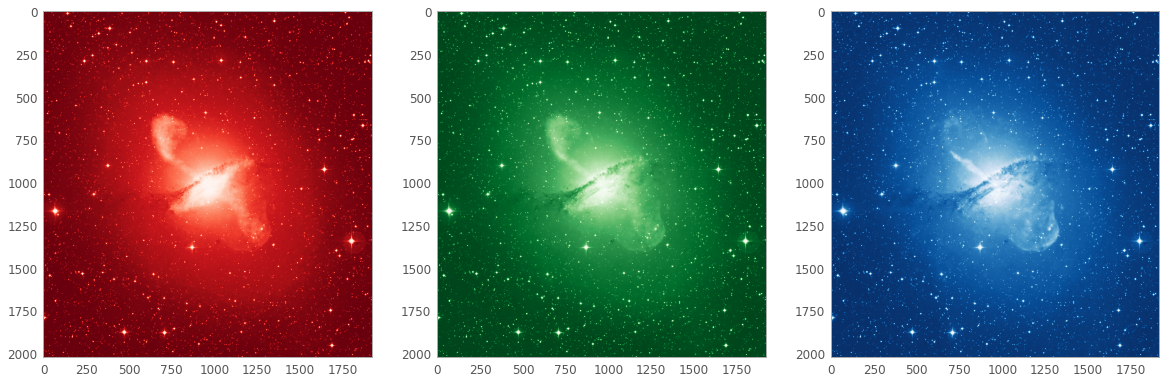

In [4]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].imshow(img[:,:,0], cmap="Reds_r") #Picks out all spatial pixels, and layer 0
ax[0].grid(None)
ax[1].imshow(img[:,:,1], cmap="Greens_r") #Picks out all spatial pixels, and layer 1
ax[1].grid(None) 
ax[2].imshow(img[:,:,2], cmap="Blues_r")  #Picks out all spatial pixels, and layer 2
ax[2].grid(None)
plt.show()


_QUESTION: what do the layers in your JPG likely represent physically (which filter, or emission line or wavelength range?)_

The Centaurus A image (which I got from Wikimedia) has a caption which says "Colour composite image of Centaurus A, revealing the lobes and jets emanating from the active galaxy’s central black hole. This is a composite of images obtained with three instruments, operating at very different wavelengths. The 870-micron submillimetre data, from LABOCA on APEX, are shown in orange. X-ray data from the Chandra X-ray Observatory are shown in blue. Visible light data from the Wide Field Imager (WFI) on the MPG/ESO 2.2 m telescope located at La Silla, Chile, show the background stars and the galaxy’s characteristic dust lane in close to "true colour".

It's interesting how the upper jet is brighter in the red channel. and the lower bubble brighter in blue (X-ray). To make "true colour" (whitish) stars, they have roughly equal brightness in all three channels. 



### Extract the Pixel Values

As we noted, the values of the pixels in the three layers are compressed for file storage, so don't contain scientific quality data. You can still extract the data though. 

In [5]:
reddata=np.array(img[:,:,0]) #Pixel values of the red layer (or channel)
bluedata=np.array(img[:,:,1])
greendata=np.array(img[:,:,2])

In [6]:
# These are still 2D arrays, so for some things you want to unravel them 
# (make them into a single array or list). This will show you how this is a 2D array. 
reddata

array([[5, 4, 0, ..., 1, 2, 2],
       [3, 5, 3, ..., 1, 2, 2],
       [0, 3, 3, ..., 1, 1, 2],
       ...,
       [1, 1, 1, ..., 4, 3, 3],
       [1, 1, 1, ..., 5, 5, 6],
       [2, 2, 1, ..., 6, 7, 7]], dtype=uint8)

In [7]:
reddata = reddata.flatten() #Flatten into a 1D array
bluedata = bluedata.flatten()
greendata=greendata.flatten()

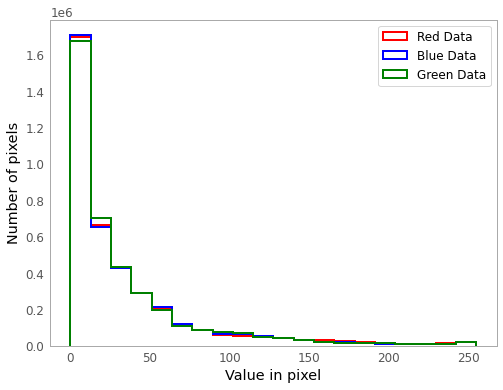

In [8]:
#Histogram plot
numberbins=20 #Set number of bins
plt.hist(reddata,histtype='step',color='Red',linewidth=2,label='Red Data',bins=numberbins)
plt.hist(bluedata,histtype='step',color='Blue',linewidth=2,label='Blue Data',bins=numberbins)
plt.hist(greendata,histtype='step',color='Green',linewidth=2,label='Green Data',bins=numberbins)
plt.grid(None)
plt.xlabel('Value in pixel')
plt.ylabel('Number of pixels')
plt.legend()
plt.show()

_QUESTION: Comment on what you see in your chosen image._

The flux in this image is pretty equally distributed between the three channels. 



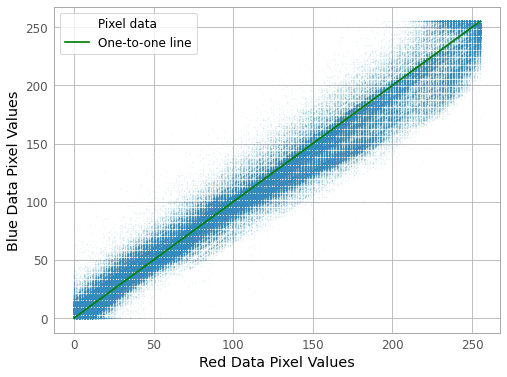

In [9]:
# Scatter plot

#Code for plot using alpha
plt.scatter(reddata, bluedata,alpha=0.1,s=0.1,label='Pixel data')
plt.plot([0,max(reddata)],[0,max(reddata)],color='Green',label='One-to-one line')
plt.xlabel('Red Data Pixel Values')
plt.ylabel('Blue Data Pixel Values')
plt.legend()
plt.show() 

_QUESTION: Comment on the scatter plot of pixel values from your image._ 

(If there are a lot of pixels, this plot can take a while). 

One thing I notice about this is that for pixels with low flux values, they are pretty close to 1-1 while the brightest pixels are tending to be slightly more red. 

_EXCERCISE: Find a JPG image of your favourite galaxy (or a galaxy you think is interesting) and redo what I did for the Centaurus A galaxy image._

## The Data in a FITS Image

FITS (flexible image transfer system) is the standard astronomical data file. I made a [video where I explained FITS files](https://www.youtube.com/watch?v=Dj8zF5fX4o0) a while ago (for ASTR341).  

As noted in that video, FITS file contain both data (in many layers - sometimes many more than three) and also a header. FITS can also hold table data, but in this Notebook we'll explore some FITS images and cubes. 


### Centaurus A FITS images

_EXCERCISE:  Go to the [NASA Extragalactic Database](https://ned.ipac.caltech.edu/) and search for Centaurus A (otherwise known as NGC 5128) and find an optical DSS images (FITS file) and radio continuum image (FITS file)._ 

Hint: there's a tab for images. There's a lot for Cen A, and the radio may be on a second page as they are in order of increasing wavelength (except the  optical one is first). The files I used for this are called: 
* NGC_5128_I_IIIaJ_dss1.fits
* NGC_5128_I_21cm_chs1996.fits

_Once you have them, make sure to upload to the Notebook server you are using. Then..._ 

In [10]:
optical_file = get_pkg_data_filename('NGC_5128_I_IIIaJ_dss1.fits')
radio_file = get_pkg_data_filename('NGC_5128_I_21cm_chs1996.fits')

In [11]:
#Look at the optical data - it is a single image with dimension 1095x1095
fits.info(optical_file)

Filename: NGC_5128_I_IIIaJ_dss1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     106   (1095, 1095)   int16   


In [12]:
#Look at the header
optical_header = fits.getheader(optical_file, ext=0)
optical_header

SIMPLE  =                    T /FITS header                                     
BITPIX  =                   16 /No.Bits per pixel                               
NAXIS   =                    2 /No.dimensions                                   
NAXIS1  =                 1095 /Length X axis                                   
NAXIS2  =                 1095 /Length Y axis                                   
DATE    = '14/11/96          ' /Date of FITS file creation                      
ORIGIN  = 'CASB -- STScI     ' /Origin of FITS image                            
PLTLABEL= 'J 1313            ' /Observatory plate label                         
PLATEID = '00AK              ' /GSSS Plate ID                                   
REGION  = 'S270              ' /GSSS Region Name                                
DATE-OBS= '11/03/75          ' /UT date of Observation                          
UT      = '15:40:00.00       ' /UT time of observation                          
EPOCH   =  1.9751907958984E+

_QUESTION: When was this data taken, and when was the FITS file created?_

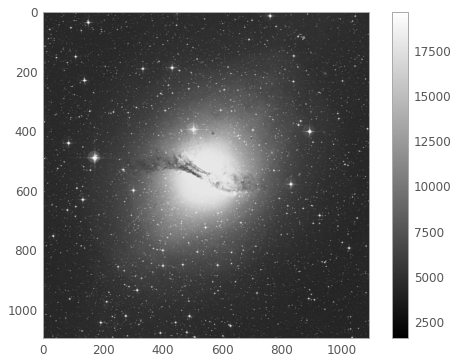

In [13]:
#Extract and plot the data

optical_data = fits.getdata(optical_file, ext=0)

plt.figure()
plt.imshow(optical_data, cmap='gray')
plt.grid(False)
plt.colorbar()

### FITS files hold real data

Unlike the pixel values in a JPG, the pixel values in a fits file usually contain calibrated flux data (in some units). In the case of the DSS images, this is scans from a photographic survey of the sky. Data from scientific digital cameras might be in the form of electron counts, or be calibrated to fluxes, or magnitudes. 

Sometimes that means the projection is better in a different scaling (e.g. log-scaling). You can play with if you see more the peak, or the low surface brightness values by changing vmin and vmax below. If you leave these out, some algorithm picks a good option it looks like! 

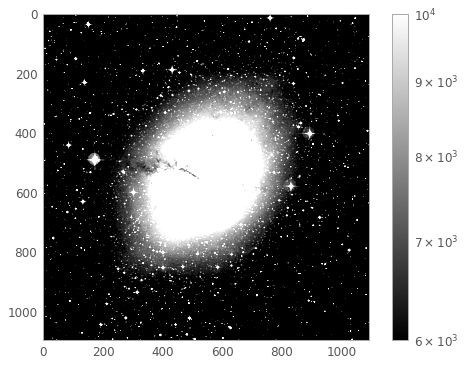

In [14]:
# Plotting with different conversion from pixel value to screen brightness/colour. 
plt.figure()
plt.imshow(optical_data, cmap='gray',norm=LogNorm(vmin=6000, vmax=10000))
plt.grid(None)
plt.colorbar()

You can also play with the colour map for the display using [Matplotlib colormaps](https://matplotlib.org/stable/users/explain/colors/colormaps.html)

In [15]:
#List your options
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

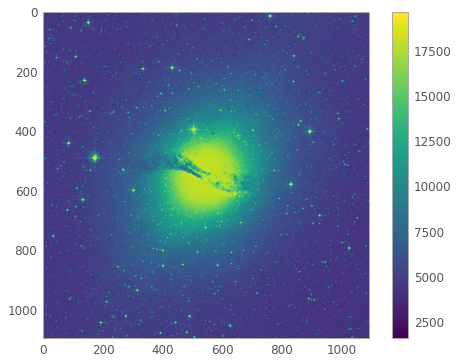

In [16]:
# Plotting with different conversion from pixel value to screen brightness/colour. 
plt.figure()
plt.imshow(optical_data, cmap='viridis')
plt.grid(None)
plt.colorbar()

## WCS Co-ordinates

WCS (World Coordinate System) https://fits.gsfc.nasa.gov/fits_wcs.html are a method to save full co-ordinate data, these are usually found in the header of FITS images saved by astronomical observatories. 

(this next bit modified from this astropy tutorial: https://learn.astropy.org/tutorials/celestial_coords1.html) 

Most of the time we can obtain the required astropy.wcs.WCS object from the header of the FITS file from a telescope or astronomical database. This process is described below.

In [17]:
wcs_optical = WCS(optical_header) #optical_header should be the header of your optical data fits file
wcs_optical

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 203.75167054166667  -45.255559775  
CRPIX : -3113.377226919317  -4162.366209236756  
PC1_1 PC1_2  : 0.02528397338855123  0.00019030160461453566  
PC2_1 PC2_2  : -0.00018789196063659835  0.025283512438371805  
CDELT : -0.018674327300797336  0.018674327300797336  
NAXIS : 1095  1095

In [18]:
# Convert to other co-ordinates (this picks out a central couple of pixels)
coord = wcs_optical.pixel_to_world([500, 501], [500, 501])  
coord  

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(201.39442015, -43.0418265 ), (201.39378807, -43.04134455)]>

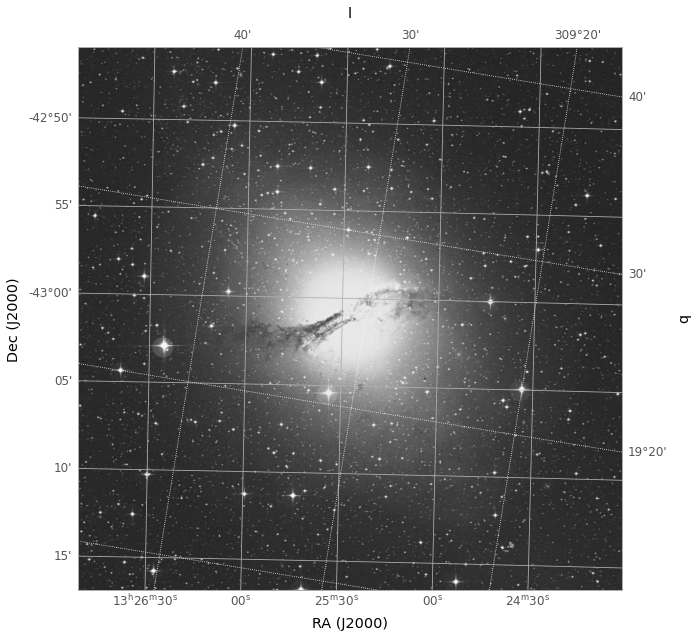

In [19]:
# Plot with co-ordinates shown 

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs_optical)
plt.imshow(optical_data, origin='lower', cmap='gray', aspect='equal')
plt.xlabel(r'RA (J2000)')
plt.ylabel(r'Dec (J2000)')
plt.grid()

#Overlay Galactic co-ordinates
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='white', ls='dotted')
plt.show()

_QUESTIONS: What does J2000 mean? Why should this be specified for RA and Dec? At what Galactic latitude (roughly) is Cen A?_

## Now the Radio Data

Radio data can be more complex than optical, because it will often be in the form of a cube. 

If we read it in the same way as an optical file we can spot that right away (and generate lots of error messages sometimes!). Even though the file we picked only has a single layer in each dimension! 

In [20]:
radio_data = fits.getdata(radio_file, ext=0)
print(radio_data.shape)

(1, 1, 512, 512)


The WCS is also more multi-dimensional, and includes units of the other dimensions. 

In [21]:
radioheader = fits.getheader(radio_file, ext=0) #Look at this (uncomment the below)
#It's LONG! Please rerun with this commented out again before you turn in. 
#radioheader

_QUESTION: From the radio header - when and where was this data taken?_

In [22]:
wcs_radio=WCS(radioheader)
wcs_radio

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 200.6325  -42.7583333333  1425000000.0  1.0  
CRPIX : 256.0  257.0  1.0  1.0  
NAXIS : 512  512  1  1

In [23]:
coord = wcs_radio.pixel_to_world([250, 251], [250, 251], [1,1],[1,1])  
coord  

[<SkyCoord (FK4: equinox=1950.0, obstime=1950.0): (ra, dec) in deg
     [(200.64006738, -42.76499975), (200.6385538 , -42.76388873)]>,
 <SpectralCoord 
    (target: <FK4 Coordinate (equinox=1950.0, obstime=1950.0): (ra, dec, distance) in (deg, deg, kpc)
                 (200.6325, -42.75833333, 1000.)
              (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                 (0., 0., -0.)>)
   [1.475e+09, 1.475e+09] Hz>,
 <Quantity [2., 2.]>]

### Plot with "squeeze" and "slice"

You can "squeeze" the radio data to plot it as an image, and slice the WCS to get the bits you need. 

In [24]:
radio_data=np.squeeze(radio_data,axis=(0,1))
print(radio_data.shape)

(512, 512)


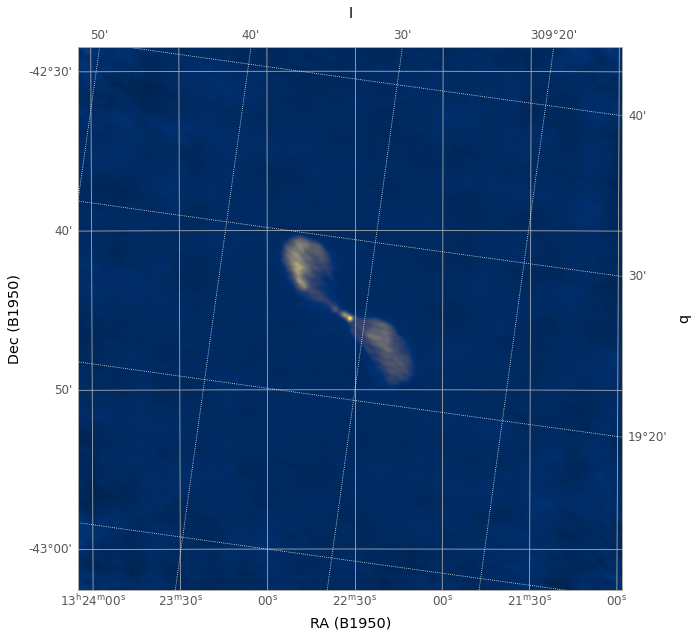

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs_radio,slices=('x','y',1,1))
plt.imshow(radio_data, origin='lower', cmap='cividis', aspect='equal')
plt.xlabel(r'RA (B1950)')
plt.ylabel(r'Dec (B1950)')
plt.grid()

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='white', ls='dotted')
plt.show()

## Plot Both Images

Text(0.5, 1.0, 'VLA 21cm Continuum')

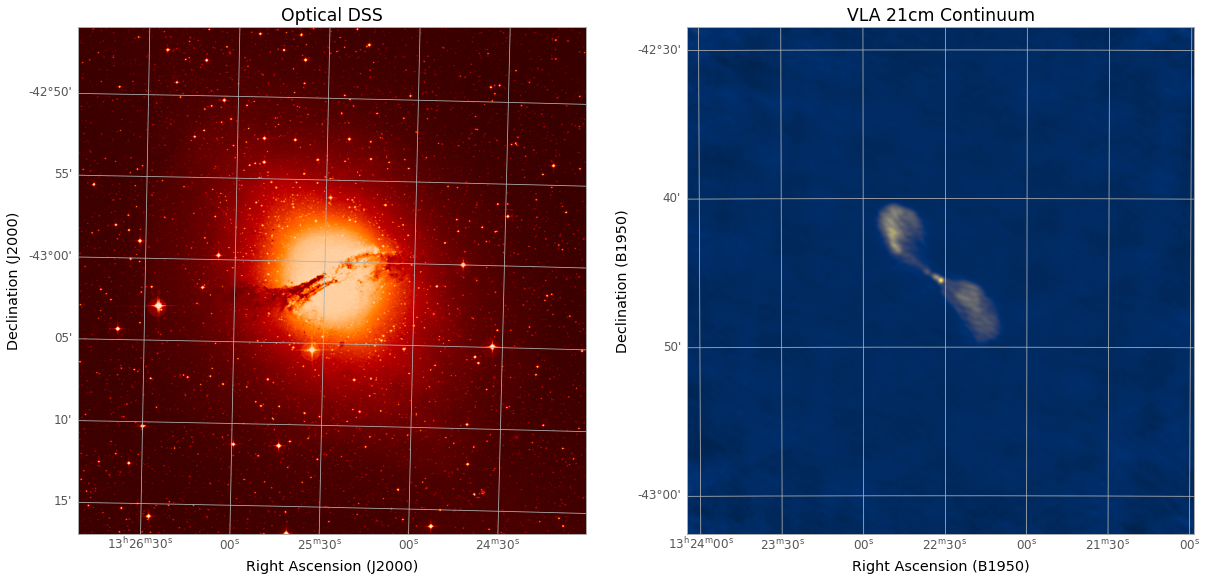

In [26]:
## Plot them next to each other
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1,2,1, projection=wcs_optical) 
ax1.imshow(optical_data, origin='lower') #vmin, vmax to change scaling
ax1.coords['ra'].set_axislabel('Right Ascension (J2000)')
ax1.coords['dec'].set_axislabel('Declination (J2000)')
ax1.set_title('Optical DSS')

ax2 = plt.subplot(1,2,2, projection=wcs_radio,slices=('x','y',1,1))
ax2.imshow(radio_data, origin='lower', cmap='cividis')
ax2.coords['ra'].set_axislabel('Right Ascension (B1950)')
ax2.coords['dec'].set_axislabel('Declination (B1950)')
ax2.set_title('VLA 21cm Continuum')

If these were both single channel images, it's easy to use [Reproject](https://reproject.readthedocs.io/en/stable/index.html#quick-start) to overplot them. I suspect it's possibe to use even with these, but I just got a ton of errors. Instead I followed the [Working with FITS Cubes (astropy)](https://learn.astropy.org/tutorials/FITS-cubes.html) tutorial, so we will do that. 

### Load A Cube

In [27]:
cube = SpectralCube.read('NGC_5128_I_21cm_chs1996.fits')
print(cube)

SpectralCube with shape=(1, 512, 512) and unit=Jy / beam:
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   200.243301 deg:  201.020178 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -43.042128 deg:  -42.474349 deg
 n_s:      1  type_s: FREQ      unit_s: Hz     range: 1425000000.000 Hz:1425000000.000 Hz


### Extract the Intensity (Moment 0 aka the "mean")

[Moments](https://en.wikipedia.org/wiki/Moment_(mathematics)) are just different orders of the expected value. So moment 0 is the mean, moment 1 is the variance, etc. Radio astronomers often use them to extract the intensity, velocity, skewness of data cubes. 

Conveniently, `moment_0` is also a regular image file. 

In [28]:
moment_0 = cube.moment(order=0)  # Zero-th moment 

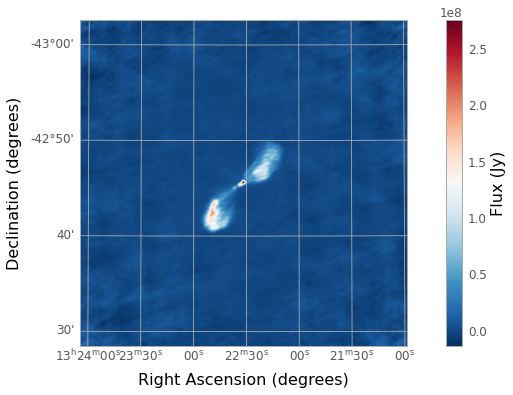

In [29]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=moment_0.wcs)

# Display the moment map image
im = ax.imshow(moment_0.hdu.data, cmap='RdBu_r')
ax.invert_yaxis()  # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Right Ascension (degrees)", fontsize=16)
ax.set_ylabel("Declination (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Flux (Jy)', size=16)

### Overlaying

Now we have two regular, single channel images, we can do this:

(-0.5, 1094.5)

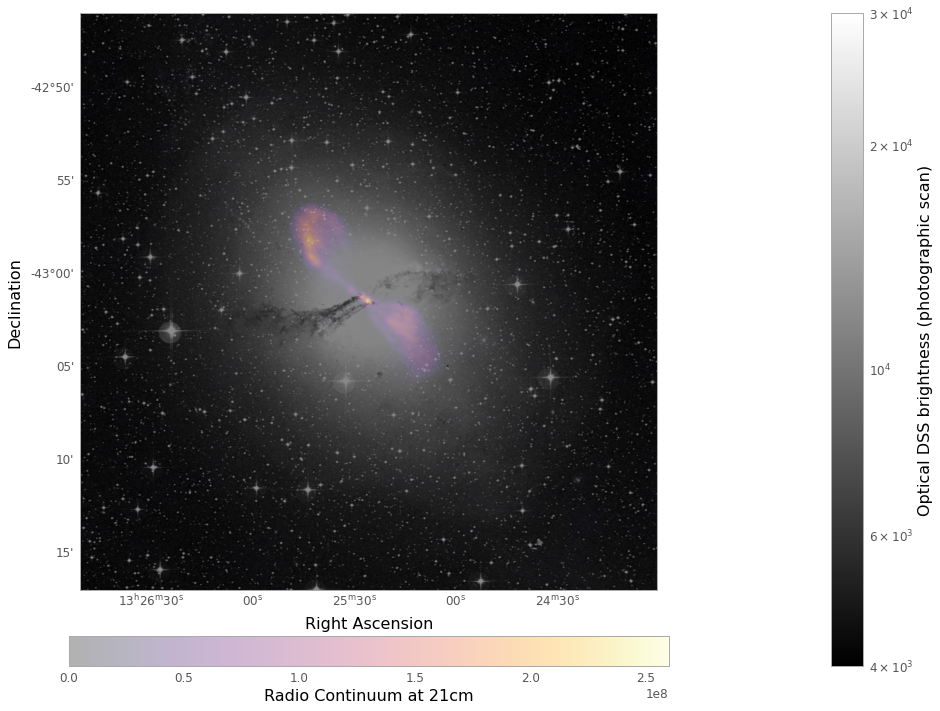

In [30]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=wcs_optical)

# Display the optical image
im = ax.imshow(optical_data, cmap='gray', alpha=1, norm=LogNorm(vmin=4000, vmax=30000))
#norm=LogNorm(vmin=4000, vmax=30000) #Sets display colours. 
#If you increase min you get more black. Increaing max gives less white. 
# ax.invert_yaxis() # Flips the Y axis 

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label(''.join(['Optical DSS brightness (photographic scan)']), size = 16)

# Add axes labels
ax.set_xlabel("Right Ascension", fontsize = 16)
ax.set_ylabel("Declination", fontsize = 16)
ax.grid(color = 'white', ls = 'dotted', lw = 2)

# Extract x and y coordinate limits
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

#Transform radio data to correct co-ordinates
radio_transform = ax.get_transform(moment_0.wcs) # extract axes Transform information for the Radio data

# Overplot radio image 
im_radio = ax.imshow(moment_0.hdu.data, cmap = 'inferno', vmin = 0, vmax = 2.6e8, alpha = 0.3, transform = radio_transform)
#vmin = 0, vmax = 200 #for linear scaling

# Add a second colorbar for the Radio Intensity information
cbar_radio = plt.colorbar(im_radio, orientation = 'horizontal', fraction=0.046, pad=0.07)
cbar_radio.set_label('Radio Continuum at 21cm', size = 16)

# Apply original image x and y coordinate limits
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

_EXERCISE: Tweak the plot above to have a different colour scale for one or both of the images._

(One thing I was thinking of playing with but didn't get to was a colour bar for the radio with variying alpha making it transparent where there's little flux so we can see the optical background better.) 

_EXTENSION: Pick a different galaxy (or a different wavelength, or both) and do this again_